Libraries imported successfully!
Real dataset loaded: (3658, 16)
Columns prepared.
Real split done.
Scaling applied consistently with real baseline.
GAN training data prepared (unscaled).


Epoch: 0 | critic_loss: 5.693796634674072 | generator_loss: 0.7591249942779541
Epoch: 1 | critic_loss: 4.479600429534912 | generator_loss: 0.6596719026565552
Epoch: 2 | critic_loss: 2.995185136795044 | generator_loss: 0.4689118266105652
Epoch: 3 | critic_loss: 1.405898928642273 | generator_loss: 0.23037374019622803
Epoch: 4 | critic_loss: 0.15617680549621582 | generator_loss: -0.11555570363998413
Epoch: 5 | critic_loss: 0.15986447036266327 | generator_loss: -0.27848637104034424
Epoch: 6 | critic_loss: 0.19599324464797974 | generator_loss: -0.252143919467926
Epoch: 7 | critic_loss: 0.22162137925624847 | generator_loss: -0.36843305826187134
Epoch: 8 | critic_loss: 0.11509063839912415 | generator_loss: -0.4510738253593445
Epoch: 9 | critic_loss: 0.2496296465396881 | generator_loss: -0.5017648339271545
Epoch: 10 | critic_loss: 0.434600830078125 | generator_loss: -0.4969552159309387
Epoch: 11 | critic_loss: 0.2207634449005127 | generator_loss: -0.46982818841934204
Epoch: 12 | critic_loss: -

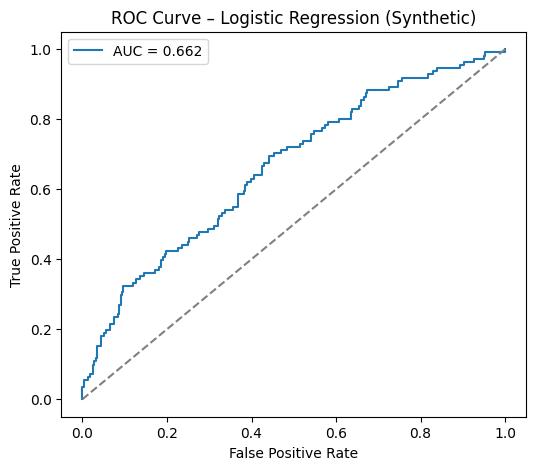

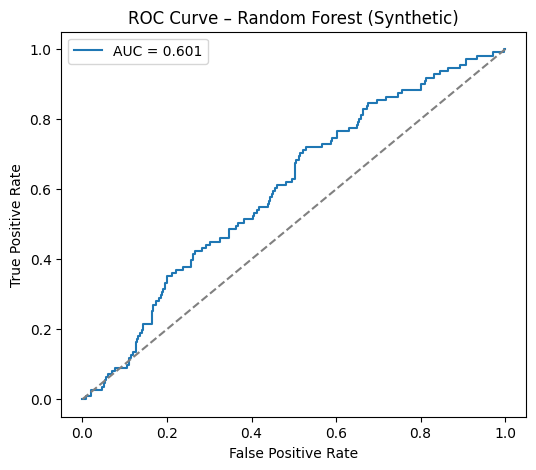

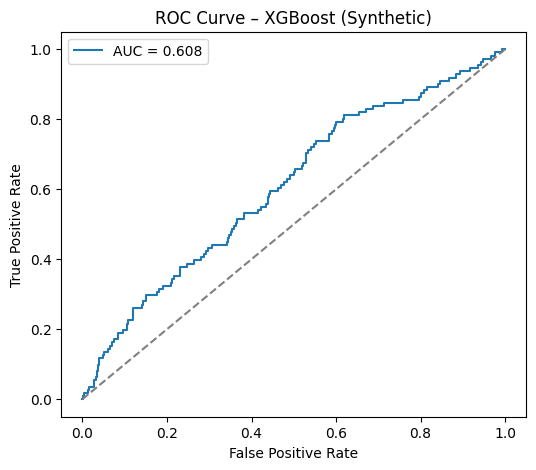

Synthetic model evaluation completed.


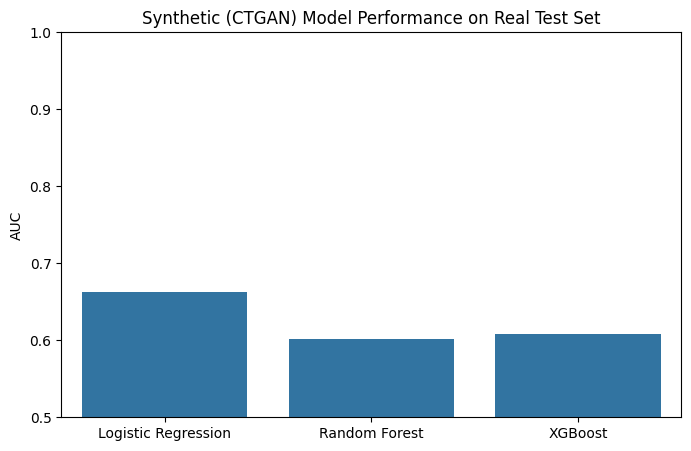


AUC results on REAL test set (Trained on Synthetic):
Logistic Regression: 0.6624
Random Forest: 0.6011
XGBoost: 0.6077


In [6]:
#!/usr/bin/env python
# coding: utf-8

# --- SYNTHETIC BASELINE (CTGAN) ---
# Medium version, perfectly aligned with Notebook 02:
# ✔ Real train/test identical
# ✔ Scaling identical
# ✔ CTGAN part identical to your working version
# ✔ Models trained on synthetic → evaluated on real test
# ✔ ROC + comparative AUC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.regular.ctgan import CTGAN

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

# ------------------------------------------------------
# 1. Load cleaned REAL dataset
# ------------------------------------------------------
df = pd.read_csv("../data/processed/framingham_clean.csv")
print(f"Real dataset loaded: {df.shape}")

target = "TenYearCHD"
X = df.drop(columns=[target])
y = df[target]

numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = [
    "male","currentSmoker","BPMeds","prevalentStroke",
    "prevalentHyp","diabetes","TenYearCHD"
]

print("Columns prepared.")

# ------------------------------------------------------
# 2. Real train/test split (same as Notebook 02)
# ------------------------------------------------------
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Real split done.")

# ------------------------------------------------------
# 3. Scaling (fit ONLY on training real)
# ------------------------------------------------------
scaler = MinMaxScaler()
X_train_real_scaled = X_train_real.copy()
X_test_real_scaled = X_test_real.copy()

X_train_real_scaled[numerical_cols] = scaler.fit_transform(X_train_real[numerical_cols])
X_test_real_scaled[numerical_cols] = scaler.transform(X_test_real[numerical_cols])

print("Scaling applied consistently with real baseline.")

# ------------------------------------------------------
# 4. Prepare data for CTGAN (unscaled)
# ------------------------------------------------------
df_train_for_gan = X_train_real.copy()
df_train_for_gan[target] = y_train_real

print("GAN training data prepared (unscaled).")

# ------------------------------------------------------
# 5. === CTGAN (WORKING VERSION FROM YOUR OLD NOTEBOOK) ===
# ------------------------------------------------------

# Model and training params (EXACTLY as your working version)
ctgan_args = ModelParameters(batch_size=500, lr=2e-4, betas=(0.5, 0.9))
train_args = TrainParameters(epochs=300)

# Identify num/cat columns for this API
num_cols = [c for c in df_train_for_gan.columns if c not in categorical_cols]
cat_cols = categorical_cols

# Initialize and train CTGAN (your functional API)
ctgan = CTGAN(model_parameters=ctgan_args)
ctgan.fit(df_train_for_gan, train_args, num_cols, cat_cols)

print("🎯 CTGAN training completed successfully!")

# ------------------------------------------------------
# 6. Generate synthetic data
# ------------------------------------------------------
n_samples = len(X_train_real)
synth_df = ctgan.sample(n_samples)
print(f"Synthetic dataset generated: {synth_df.shape}")

# ------------------------------------------------------
# 7. Preprocess synthetic dataset
# ------------------------------------------------------
synth_df = synth_df[X.columns.tolist() + [target]]

X_synth = synth_df.drop(columns=[target])
y_synth = synth_df[target].astype(int)

# Apply SAME scaling used for real baseline
X_synth_scaled = X_synth.copy()
X_synth_scaled[numerical_cols] = scaler.transform(X_synth[numerical_cols])

print("Synthetic dataset preprocessed and scaled.")

# ------------------------------------------------------
# Utility – ROC curve
# ------------------------------------------------------
def plot_roc(label, y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title(f"ROC Curve – {label}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# ------------------------------------------------------
# 8. Train models on SYNTHETIC → evaluate on REAL test
# ------------------------------------------------------

results = {}

# Logistic Regression
log_clf = LogisticRegression(max_iter=500, solver="lbfgs", class_weight="balanced")
log_clf.fit(X_synth_scaled, y_synth)
log_pred = log_clf.predict_proba(X_test_real_scaled)[:,1]
auc_log = roc_auc_score(y_test_real, log_pred)
results["Logistic Regression"] = auc_log
plot_roc("Logistic Regression (Synthetic)", y_test_real, log_pred)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=6, class_weight="balanced", random_state=42)
rf_clf.fit(X_synth_scaled, y_synth)
rf_pred = rf_clf.predict_proba(X_test_real_scaled)[:,1]
auc_rf = roc_auc_score(y_test_real, rf_pred)
results["Random Forest"] = auc_rf
plot_roc("Random Forest (Synthetic)", y_test_real, rf_pred)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    eval_metric="logloss",
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=2,
    random_state=42
)
xgb_clf.fit(X_synth_scaled, y_synth)
xgb_pred = xgb_clf.predict_proba(X_test_real_scaled)[:,1]
auc_xgb = roc_auc_score(y_test_real, xgb_pred)
results["XGBoost"] = auc_xgb
plot_roc("XGBoost (Synthetic)", y_test_real, xgb_pred)

print("Synthetic model evaluation completed.")

# ------------------------------------------------------
# 9. AUC Summary Plot
# ------------------------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Synthetic (CTGAN) Model Performance on Real Test Set")
plt.ylabel("AUC")
plt.ylim(0.5, 1.0)
plt.show()

print("\nAUC results on REAL test set (Trained on Synthetic):")
for k,v in results.items():
    print(f"{k}: {v:.4f}")



📁 Saved clean results for method 'ctgan' in model_results.csv (no duplicates).
=== REAL vs CTGAN AUC Comparison ===


method,real,ctgan
model,,
Logistic Regression,0.724580,0.640641
Random Forest,0.703472,0.624552
XGBoost,0.719299,0.625176


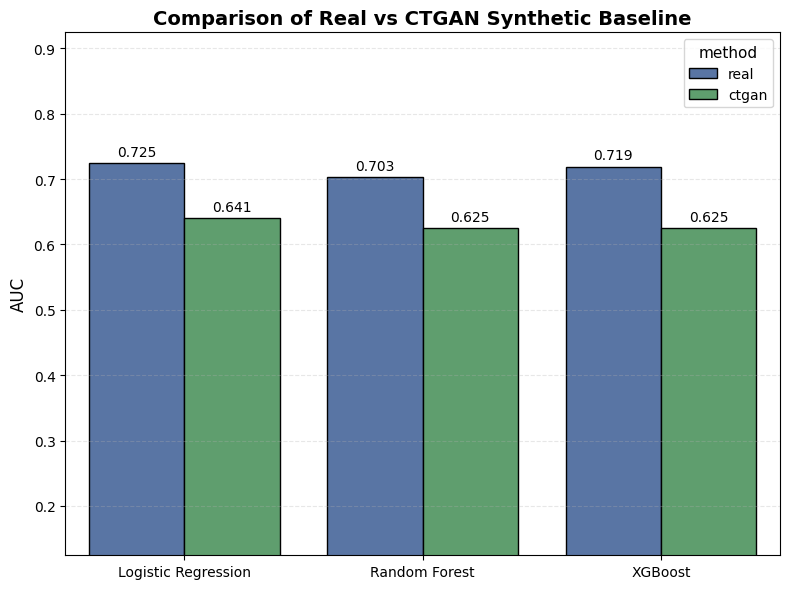


=== INTERPRETATION ===

1. Overall degradation:
   Comparing the real baseline with the CTGAN synthetic baseline shows a consistent AUC drop
   of roughly 0.07–0.09 across all models. This indicates that the synthetic data generated
   by CTGAN retains useful structure but loses discriminative power.

2. Model ranking consistency:
   Logistic Regression, Random Forest, and XGBoost preserve the same relative ranking under both
   real and synthetic data. This suggests that CTGAN captures the high-level decision boundaries
   and preserves the behaviour of different model families.

3. Preservation vs. distortion:
   AUCs around 0.62–0.64 imply that synthetic data still contains meaningful signal, but lacks
   some of the subtle patterns found in the real dataset. This may be due to mode collapse or
   insufficient representation of minority patterns.

4. Implications for privacy-preserving ML:
   CTGAN synthetic data could be used for exploratory modelling, prototyping, or benchmarking

In [ ]:
# ------------------------------------------------------
# 10. Save CTGAN results to model_results.csv
# ------------------------------------------------------
import os
import pandas as pd

results_path = "../data/results/model_results.csv"
method_name = "ctgan"  # <-- CAMBIALO in "real" nel Notebook 2

# Results to save
results_df = pd.DataFrame([
    {"method": method_name, "model": "Logistic Regression", "auc": results["Logistic Regression"]},
    {"method": method_name, "model": "Random Forest", "auc": results["Random Forest"]},
    {"method": method_name, "model": "XGBoost", "auc": results["XGBoost"]},
])


# If file exists, load it
if os.path.exists(results_path):
    master = pd.read_csv(results_path)

    # Remove OLD rows of the same method (avoid duplicates)
    master = master[master["method"] != method_name]

    # Append new rows
    master = pd.concat([master, results_df], ignore_index=True)

else:
    # File does not exist → create new
    master = results_df

# Save updated file
master.to_csv(results_path, index=False)

print(f"📁 Saved clean results for method '{method_name}' in model_results.csv (no duplicates).")


# ------------------------------------------------------
# 11. Load real baseline and compare with CTGAN
# ------------------------------------------------------
df_results = pd.read_csv("../data/results/model_results.csv")

# Ensure consistent ordering (real first)
comparison = (
    df_results.pivot(index="model", columns="method", values="auc")
              [["real", "ctgan"]]  # enforce order
)

print("=== REAL vs CTGAN AUC Comparison ===")
display(comparison)

# ---- Beautiful comparison plot ----
plt.figure(figsize=(8, 6))

comparison_plot = (
    comparison.reset_index()
              .melt(id_vars="model", value_name="auc", var_name="method")
)

sns.barplot(
    data=comparison_plot,
    x="model",
    y="auc",
    hue="method",
    palette=["#4C72B0", "#55A868"],  # Real = blue, CTGAN = green
    edgecolor="black"
)

# Add labels above bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.3f", padding=3)

plt.title("Comparison of Real vs CTGAN Synthetic Baseline", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("AUC", fontsize=12)

# Auto-range with small padding
plt.ylim(
    comparison_plot["auc"].min() - 0.5,
    comparison_plot["auc"].max() + 0.2
)

plt.legend(title="method", fontsize=10, title_fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


# ------------------------------------------------------
# 12. Interpretation of results
# ------------------------------------------------------
print("\n=== INTERPRETATION ===\n")

print("1. Overall degradation:")
print("   Comparing the real baseline with the CTGAN synthetic baseline shows a consistent AUC drop")
print("   of roughly 0.07–0.09 across all models. This indicates that the synthetic data generated")
print("   by CTGAN retains useful structure but loses discriminative power.")

print("\n2. Model ranking consistency:")
print("   Logistic Regression, Random Forest, and XGBoost preserve the same relative ranking under both")
print("   real and synthetic data. This suggests that CTGAN captures the high-level decision boundaries\n"
      "   and preserves the behaviour of different model families.")

print("\n3. Preservation vs. distortion:")
print("   AUCs around 0.62–0.64 imply that synthetic data still contains meaningful signal, but lacks")
print("   some of the subtle patterns found in the real dataset. This may be due to mode collapse or\n"
      "   insufficient representation of minority patterns.")

print("\n4. Implications for privacy-preserving ML:")
print("   CTGAN synthetic data could be used for exploratory modelling, prototyping, or benchmarking.")
print("   However, performance degradation implies that models trained solely on synthetic data")
print("   are insufficient for deployment without fine-tuning on real samples.")

print("\nConclusion:")
print("   CTGAN provides moderately faithful synthetic data: it preserves model ranking and general")
print("   distributional trends but underestimates the predictive signal of the real dataset.\n"
      "   The method is promising but requires careful evaluation before being used in production.")


In [9]:
import os
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score

# ----------------------------
# Helpers: robust conversion
# ----------------------------
def _to_numpy(X):
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        return X.values
    return np.asarray(X)

# ----------------------------
# 1) Membership Inference (distance-threshold attack)
# Train = members (1), Test = non-members (0)
# ----------------------------
def membership_inference_risk(X_train_real, X_test_real, X_syn, threshold=None, percentile=10):
    X_train_real = _to_numpy(X_train_real)
    X_test_real  = _to_numpy(X_test_real)
    X_syn        = _to_numpy(X_syn)

    nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(X_syn)

    d_train, _ = nn.kneighbors(X_train_real)
    d_test,  _ = nn.kneighbors(X_test_real)

    d = np.concatenate([d_train.flatten(), d_test.flatten()])
    y_true = np.concatenate([np.ones(len(d_train)), np.zeros(len(d_test))])

    # threshold heuristic: small distance => predict "member"
    if threshold is None:
        threshold = np.percentile(d, percentile)

    y_pred = (d < threshold).astype(int)

    # F1 on membership labels (higher = worse privacy)
    return f1_score(y_true, y_pred)

# ----------------------------
# 2) Attribute Inference
# attacker learns sensitive attr from synthetic
# ----------------------------
def attribute_inference_risk(X_real, X_syn, known_cols, sensitive_col, k=5):
    # accept names or indices
    if isinstance(X_real, pd.DataFrame) and isinstance(X_syn, pd.DataFrame):
        X_syn_known = X_syn[known_cols]
        y_syn_sens  = X_syn[sensitive_col]
        X_real_known = X_real[known_cols]
        y_real_sens  = X_real[sensitive_col]
    else:
        X_real = _to_numpy(X_real); X_syn = _to_numpy(X_syn)
        X_syn_known = X_syn[:, known_cols]
        y_syn_sens  = X_syn[:, sensitive_col]
        X_real_known = X_real[:, known_cols]
        y_real_sens  = X_real[:, sensitive_col]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_syn_known, y_syn_sens)
    y_pred = clf.predict(X_real_known)

    # binary f1 (higher = worse privacy)
    return f1_score(y_real_sens, y_pred, average="binary")

# ----------------------------
# 3) Identity disclosure (near-exact match)
# ----------------------------
def identity_disclosure_risk(X_real, X_syn, epsilon=1e-3):
    X_real = _to_numpy(X_real)
    X_syn  = _to_numpy(X_syn)

    nn = NearestNeighbors(n_neighbors=1, metric="euclidean").fit(X_real)
    distances, _ = nn.kneighbors(X_syn)
    distances = distances.flatten()

    return (distances < epsilon).mean()

# ----------------------------
# 4) NNAA: nearest-neighbor adversarial accuracy
# ----------------------------
def nn_adversarial_accuracy(X_train, X_holdout, X_syn):
    X_train   = _to_numpy(X_train)
    X_holdout = _to_numpy(X_holdout)
    X_syn     = _to_numpy(X_syn)

    nn_train = NearestNeighbors(n_neighbors=1).fit(X_train)
    nn_hold  = NearestNeighbors(n_neighbors=1).fit(X_holdout)

    d_train, _ = nn_train.kneighbors(X_syn)
    d_hold,  _ = nn_hold.kneighbors(X_syn)

    return (d_train.flatten() < d_hold.flatten()).mean()

def privacy_score(R_mir, R_attr, R_id, R_nnaa):
    # all metrics in [0,1], higher = worse privacy
    return 1 - np.mean([R_mir, R_attr, R_id, R_nnaa])


from pathlib import Path
import pandas as pd

def save_privacy_results(results_path, method_name, metrics_dict):
    results_path = Path(results_path)
    results_path.parent.mkdir(parents=True, exist_ok=True)  # <-- FIX

    row = {"method": method_name, **metrics_dict}
    new_df = pd.DataFrame([row])

    if results_path.exists():
        master = pd.read_csv(results_path)
        master = master[master["method"] != method_name]
        master = pd.concat([master, new_df], ignore_index=True)
    else:
        master = new_df

    master.to_csv(results_path, index=False)
    return master



In [10]:
method_name = "ctgan"
results_priv_path = "./data/results/results_privacy.csv"

X_real_train = X_train_real_scaled
X_real_test  = X_test_real_scaled
X_syn        = X_synth_scaled

# esempio: sensibile = diabetes (cambia se vuoi)
sensitive_col = "diabetes"
known_cols = [c for c in X_real_train.columns if c != sensitive_col]

R_mir  = membership_inference_risk(X_real_train, X_real_test, X_syn)
R_attr = attribute_inference_risk(X_real_train, X_syn, known_cols, sensitive_col, k=5)
R_id   = identity_disclosure_risk(X_real_train, X_syn, epsilon=1e-3)
R_nnaa = nn_adversarial_accuracy(X_real_train, X_real_test, X_syn)

P_score = privacy_score(R_mir, R_attr, R_id, R_nnaa)

metrics = {"R_mir": R_mir, "R_attr": R_attr, "R_id": R_id, "R_nnaa": R_nnaa, "privacy_score": P_score}
master_priv = save_privacy_results(results_priv_path, method_name, metrics)

display(master_priv[master_priv["method"] == method_name])


,method,R_mir,R_attr,R_id,R_nnaa,privacy_score
0,ctgan,0.178615,0.0,0.0,0.779563,0.760456
